In [8]:
import numpy as np
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import manifold, datasets
from sklearn.neighbors import NearestNeighbors

Automatically created module for IPython interactive environment


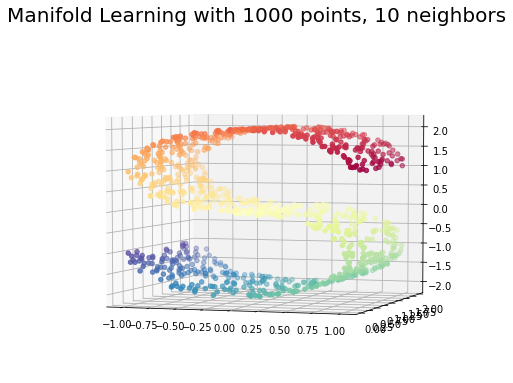

In [2]:
n_samples = 1000
n_components = 2
n_neighbors = 10

X, color = datasets.samples_generator.make_s_curve(n_samples, random_state=0)


fig = plt.figure(figsize=(8, 6))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=20)

raw_ax = fig.add_subplot(111, projection='3d')

raw_ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
raw_ax.view_init(4, -72)
plt.show()

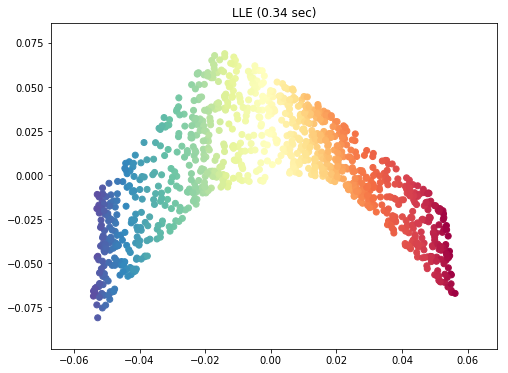

In [435]:
# LocallyLinearEmbedding

t0 = time()
Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                    eigen_solver='auto',
                                    method='standard').fit_transform(X)
t1 = time()

fig = plt.figure(figsize=(8, 6))

plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("%s (%.2g sec)" % ('LLE', t1 - t0))

plt.show()

In [424]:
# Failed: non-linear, can't center and norm data first!!!!!

# LLE: center and norm data first, no constraint to W -- FAILED
# K > P

## 1. center and norm data first

def center_norm_X(X):
    X = X.astype(float)
    X = X - np.mean(X, axis=0)

    dim = X.shape[1]
    for d in range(dim):
        x = X[:, d]
        n = np.linalg.norm(x)
        x = x/n
        X[:, d] = x
    
    return X

X = center_norm_X(X)

In [436]:
# 2. find K-Nearest and cal W

def _matrixes_matmul(matrixes):
    result = None
    length = len(matrixes)
    
    if length <= 2:
        print('Use matmul instead')
        raise
    
    for i in range(length-2):
        matrix = matrixes[i]
        if result is None:
            result = np.identity(matrix.shape[0])
        result = np.matmul(result, matrix)
    
        matrix_next = matrixes[i+1]
        result = np.matmul(result, matrix_next)
    return result

In [452]:
def cal_W(X, n_neighbors=10):
    n_samples = X.shape[0]
    W_matrix = np.zeros(shape=(n_samples, n_samples))
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)
    for i in indices:
        x_index = i[0]
        y_indices = i[1:]
        x = X[x_index]
        Y = X[y_indices]
        
        G = np.matmul(Y, Y.T)
        
        try:
            G_inv = np.linalg.inv(G)
        except:
            G_inv = np.linalg.pinv(G)
        w_val = _matrixes_matmul([x, Y.T, G_inv])
            
        np.put(W_matrix[x_index], y_indices, w_val)
    return W_matrix
        
W = cal_W(X, n_neighbors)

In [458]:
W_weights = W/np.sum(W, axis=0)

In [461]:
# 3. cal coordinates

I = np.identity(n_samples)
M = np.matmul(I - W_weights.T, I - W_weights)
eigvals, eigvects = np.linalg.eig(M)

keep_mask = np.greater(eigvals, 0)
eigvals_kept = eigvals[keep_mask]
eigvects_kept = eigvects[keep_mask]

eigvects_sorted = np.array([eigvect for _, eigvect in sorted(zip(eigvals_kept, eigvects_kept))])

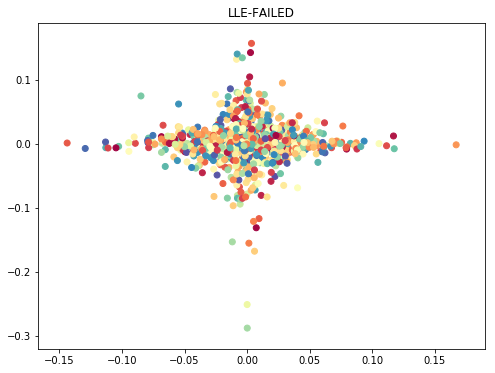

In [462]:
# 4. plot

y1 = eigvects_sorted[0]
y2 = eigvects_sorted[1]

fig = plt.figure(figsize=(8, 6))

plt.scatter(y1, y2, c=color, cmap=plt.cm.Spectral)
plt.title("LLE-FAILED")
plt.show()

In [480]:
# Use digits dataset, K < P
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

In [471]:
from sklearn.datasets import load_digits
data_bunch = load_digits(n_class=6)

In [472]:
X = data_bunch.data
y = data_bunch.target

shape = X.shape
n_samples = shape[0]
n_features = shape[1]
n_neighbors = 10
n_components = 2

Text(0.5, 1.0, 'A selection from the 64-dimensional digits dataset')

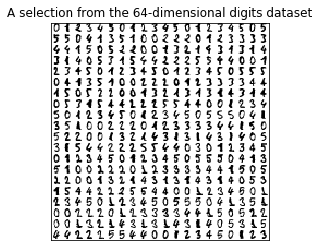

In [487]:
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

In [500]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 8))
#     ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

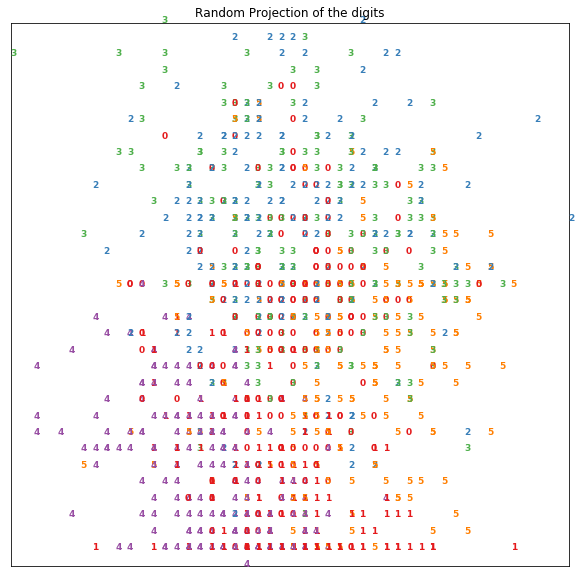

In [496]:
# 1. random projection

rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

0.28910166201917664 0.6304543043110453 0
0.5543124612326276 0.4570444607427255 1
0.5403118688084775 0.49242950634306004 2
0.2804993889293894 0.1977203283110648 3
0.15351698026823524 0.8441412138610919 4
0.6236324097621244 0.3419648979295134 5
0.4299475816841003 0.7687532507209853 0
0.4782403270906907 0.5615883913958237 1
0.2309830125443381 0.2728072196454448 2
0.46199016599143206 0.17648145035177867 3
0.556924595250511 0.9280509043452448 4
0.49801941157620955 0.35262251584573157 5
0.5508208378988673 0.7299071254021156 0
0.544741405672327 0.5358901640250131 1
0.2950305528211169 0.16251009636193023 2
0.31832047181877976 0.282747226521948 3
0.1910700333453811 0.811471933544326 4
0.2733556268143863 0.4892628803829529 5
0.48685228502874833 0.6755406831240778 0
0.6294142532919593 0.4287445540626902 5
0.6163272390872334 0.39049352538061727 5
0.5063993566420179 0.40654009246242334 5
0.5983888008318499 0.706914701852613 0
0.5894690076015064 0.9009060478244985 4
0.2904013301847142 0.572649179727

0.6322649612679618 0.4424331698045773 5
0.48787142015588736 0.6121061243118091 0
0.4119843954160223 0.821779533009714 4
0.5423262122563205 0.5784998768145465 1
0.58301302818805 0.18862653282004477 3
0.4702306430028829 0.4966550227997235 5
0.5407027816176497 0.4941035323542603 1
0.44805454084425517 0.6452269695449501 0
0.35944823729515885 0.6902458802758178 0
0.6046250255736824 0.16061072412954325 2
0.29947347762552784 0.14830829579843105 2
0.3714867108252053 0.1784777872323192 2
0.3685979457414293 0.5551368907923726 0
0.22518681513638833 0.30618471886914267 1
0.39387804457236997 0.24196727305623766 2
0.5870252609558986 0.3101561193195261 3
0.5500603117176777 0.3046700159047623 3
0.4695411322730898 0.31765111001814295 3
0.48078815535727626 0.28759790506381544 3
0.34083516050361523 0.8260510173260662 4
0.2978777040858242 0.7366696365473692 4
0.5825176281155994 0.5275945353261101 1
0.6649755156332348 0.5714303015033054 5
0.4339837215295864 0.6828653223409782 0
0.6123343592876731 0.4064890

0.5687904209436195 0.4351058222938291 1
0.44651162065651945 0.5723364545246777 5
0.19408307165225916 0.9168047417930993 4
0.2882657176303424 0.7778613682715707 4
0.40054423330954475 0.036374712036469775 2
0.48780981099227316 0.2146586950206173 2
0.5491183005197601 0.2856566445936891 2
0.5275040418173726 0.4504807008396675 5
0.4384025740632967 0.6100822448341168 5
0.43220981060791036 0.8796864200555159 4
0.4371840229960858 0.7768096856644203 4
0.28229275453753194 0.5676851326411333 0
0.2550117751332063 0.626597968887653 0
0.5277082153980962 0.5519797200170252 1
0.3912211755662775 0.06286564664921747 2
0.545649793496466 0.10111679868157743 3
0.41898957932867803 0.9220989924768868 4
0.2595676741015415 0.47726225432714986 5
0.21093192042993156 0.6589762586487921 0
0.4236037915046396 0.603291388619735 1
0.4847920893819088 0.054502050081422525 2
0.5340189215200087 0.1798802074905888 3
0.4316340356700049 0.9772017840983634 4
0.575432791798275 0.3883908131808038 5
0.2843207640415957 0.63696023

0.2982858604812687 0.5634955120312266 0
0.6605269054682523 0.7390843374669105 0
0.40491961147483796 0.4917583340159838 1
0.2195893692651957 0.24526172174277877 2
0.435247908265705 0.24799195773958718 3
0.5179438597628926 0.8223347139233329 4
0.25493688075559445 0.42885020264240625 5
0.5839898667873571 0.7114380347839766 0
0.5949448761244466 0.45529493780045627 1
0.42535718547753293 0.43181161035286186 2
0.41295733462345596 0.31630765531344474 3
0.33623738827555283 0.8295498486896541 4
0.35950455009892673 0.5581505241208302 5
0.5614517930671358 0.699666992721993 0
0.5717537881751495 0.5752310810806225 1
0.3574599637515456 0.34828054047250734 2
0.5115130441577247 0.15738644652328157 3
0.4241827507521361 0.7673863351244652 4
0.5871397669051047 0.42631623139560315 5
0.4487639403549024 0.8287812850929508 0
0.5078870580491793 0.31474799339468157 5
0.31029328099683423 0.3887778830119264 5
0.26956255426845843 0.5006005490723828 5
0.45525080954747166 0.6551898592043721 0
0.39905208288392785 0.8

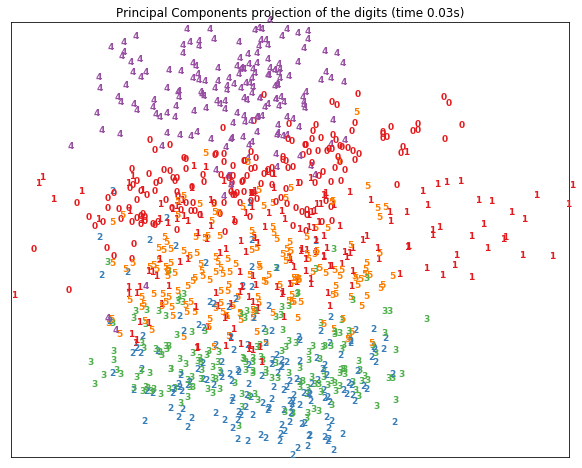

In [501]:
# 2. PCA

t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

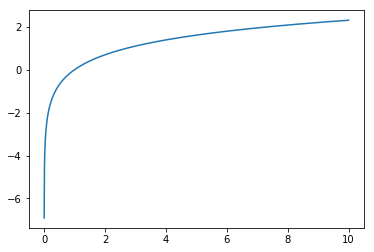

In [506]:
x = np.linspace(0.001, 10, 1000)
plt.plot(x, np.log(x))
plt.show()